# Define

In [1]:
# Install essential library
!pip3 install -U imbalanced-learn
!pip3 install attrdict --upgrade
!pip3 install click --upgrade
!pip3 install lightgbm --upgrade
!pip3 install numpy --upgrade
!pip3 install scikit-learn --upgrade
!pip3 install pyyaml --upgrade
!pip3 install xgboost --upgrade
!pip3 install catboost --upgrade
!pip3 install scikit-optimize --upgrade
!pip3 install keras --upgrade
!pip3 install ngboost
!pip3 install tensorflow==1.14

Requirement already up-to-date: imbalanced-learn in /opt/conda/lib/python3.7/site-packages (0.6.2)
Requirement already up-to-date: attrdict in /opt/conda/lib/python3.7/site-packages (2.0.1)
Requirement already up-to-date: click in /opt/conda/lib/python3.7/site-packages (7.1.2)
Requirement already up-to-date: lightgbm in /opt/conda/lib/python3.7/site-packages (2.3.1)
Requirement already up-to-date: numpy in /opt/conda/lib/python3.7/site-packages (1.18.5)
Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.7/site-packages (0.23.1)
Processing /home/jupyter/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653/PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 5.3
ERROR: Cannot uninstall 'PyYAML'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
Requirement already up-to-date: xgboost in /op

In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Garbage collector
import gc

!pip3 install ipython-autotime
%load_ext autotime

In [3]:
from scipy import interp
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.metrics import auc, plot_roc_curve, brier_score_loss

########################### ROC AUC #############################
def cross_validate_auc(model_base, kfold, features=None, evaluate = False, nn_validate=False, **clf_params):
  train_tprs = []
  train_aucs = []
  train_mean_fpr = np.linspace(0, 1, 100)
  dev_tprs = []
  dev_aucs = []
  dev_mean_fpr = np.linspace(0, 1, 100)
  fitted_models = []

  fig, ax = plt.subplots()
  fig.set_size_inches((16,10))
  print("Cross Validation: ROC AUC score")
  for i in range(0, len(kfold)):
    print("{}/{}".format(i+1, len(kfold)))
    kf = kfold[i]
    X_train_kf, y_train_kf = kf["X_train"].copy(), kf["y_train"].copy()
    X_dev_kf, y_dev_kf = kf["X_dev"].copy(), kf["y_dev"].copy()
    if features is not None:
      X_train_kf = X_train_kf[features]
      X_dev_kf = X_dev_kf[features]

    model = clone(model_base)
    
    if nn_validate == True:
      model.fit(X_train_kf, y_train_kf, validation_data=(X_dev_kf, y_dev_kf))
    elif evaluate == False:
      model.fit(X_train_kf, y_train_kf, **clf_params)
    else:
      model.fit(X_train_kf, y_train_kf, eval_set=[(X_dev_kf, y_dev_kf)],**clf_params)
    fitted_models.append(model)
    # plot train
    train_display = plot_roc_curve(model, X_train_kf, y_train_kf,
                         name='Train ROC fold {}'.format(i),
                         alpha=0.6, lw=1, ax=ax)
    train_interp_tpr = interp(train_mean_fpr, train_display.fpr, train_display.tpr)
    train_interp_tpr[0] = 0.0
    train_tprs.append(train_interp_tpr)
    train_aucs.append(train_display.roc_auc)
    # plot dev
    dev_display = plot_roc_curve(model, X_dev_kf, y_dev_kf,
                         name='Dev ROC fold {}'.format(i),
                         alpha=0.6, lw=1, ax=ax)
    dev_interp_tpr = interp(dev_mean_fpr, dev_display.fpr, dev_display.tpr)
    dev_interp_tpr[0] = 0.0
    dev_tprs.append(dev_interp_tpr)
    dev_aucs.append(dev_display.roc_auc)
  
  # plot mean train
  train_mean_tpr = np.mean(train_tprs, axis=0)
  train_mean_tpr[-1] = 1.0
  train_mean_auc = auc(train_mean_fpr, train_mean_tpr)
  train_std_auc = np.std(train_aucs)
  ax.plot(train_mean_fpr, train_mean_tpr, color='r',
        label=r'Train Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (train_mean_auc, train_std_auc),
        lw=2, alpha=1)
  # plot mean dev
  dev_mean_tpr = np.mean(dev_tprs, axis=0)
  dev_mean_tpr[-1] = 1.0
  dev_mean_auc = auc(dev_mean_fpr, dev_mean_tpr)
  dev_std_auc = np.std(dev_aucs)
  ax.plot(dev_mean_fpr, dev_mean_tpr, color='b',
        label=r'Dev Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (dev_mean_auc, dev_std_auc),
        lw=2, alpha=1)
  
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
  ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
  plt.show()

  return train_mean_auc, dev_mean_auc, fitted_models

########################### Brier score #############################
def cross_validate_brier(model_base, kfold, features=None, **clf_params):
  train_briers = []
  dev_briers = []
  fitted_models = []

  print("Cross Validation: Brier score")
  for i in range(0, len(kfold)):
    print("{}/{}".format(i+1, len(kfold)))
    kf = kfold[i]
    X_train_kf, y_train_kf = kf["X_train"].copy(), kf["y_train"].copy()
    X_dev_kf, y_dev_kf = kf["X_dev"].copy(), kf["y_dev"].copy()
    if features is not None:
      X_train_kf = X_train_kf[features]
      X_dev_kf = X_dev_kf[features]

    model = clone(model_base)
    model.fit(X_train_kf, y_train_kf, **clf_params)
    fitted_models.append(model)
    # plot train
    train_brier = brier_score_loss(y_train_kf, model.predict_proba(X_train_kf)[:,1])
    train_briers.append(train_brier)
    # plot dev
    dev_brier = brier_score_loss(y_dev_kf, model.predict_proba(X_dev_kf)[:,1])
    dev_briers.append(dev_brier)
  
  train_mean_brier = np.mean(train_briers)
  train_std_brier = np.std(train_briers)
  print("----------- Train Brier Score ----------")
  print(train_briers)
  print("Mean Brier: ", train_mean_brier)

  dev_mean_brier = np.mean(dev_briers)
  dev_std_brier = np.std(dev_briers)
  print("----------- Dev Brier Score ----------")
  print(dev_briers)
  print("Mean Brier: ", dev_mean_brier)

  return train_mean_brier, dev_mean_brier, fitted_models

time: 31.6 ms


# Kfold

In [4]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# kfold = []
# for i in range(0,5):
#   X_train = pd.read_csv("./cv_input/X_train_preprocessed_{}.csv".format(i + 1))
#   y_train = pd.read_csv("./cv_input/y_train_{}.csv".format(i + 1))
#   X_dev = pd.read_csv("./cv_input/X_dev_preprocessed_{}.csv".format(i + 1))
#   y_dev = pd.read_csv("./cv_input/y_dev_{}.csv".format(i + 1))
#   X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
#   X_dev = pd.DataFrame(scaler.transform(X_dev), columns = X_dev.columns)
#   kfold.append({
#       "X_train": X_train,
#       "y_train": y_train['label'],
#       "X_dev": X_dev,
#       "y_dev": y_dev['label'],
#   })


time: 42.1 s


In [5]:
# duplicates = []
# for i in range(5):
#   duplicate = []
#   for col in kfold[i]['X_train']:
#     if col.find('.1') != -1:
#       duplicate.append(col)
#   duplicates.append(duplicate)

# for i in range(5):
#   kfold[i]['X_train'] = kfold[i]['X_train'].drop(columns=duplicates[i])
#   kfold[i]['X_dev'] = kfold[i]['X_dev'].drop(columns=duplicates[i])


time: 642 ms


In [6]:
# for i in range(0, 5):
#   print(kfold[i]['X_train'].shape)
#   print(kfold[i]['X_dev'].shape)

(24000, 1392)
(6000, 1392)
(24000, 1381)
(6000, 1381)
(24000, 1444)
(6000, 1444)
(24000, 1409)
(6000, 1409)
(24000, 1403)
(6000, 1403)
time: 2.85 ms


In [7]:
# # Covariate shilt
# dropped_cols = ['FIELD_3',
#  'stats_mean_FIELD_10_incomplete',
#  'stats_mean_FIELD_8_FIELD_55',
#  'FIELD_3',
#  'stats_mean_FIELD_8_FIELD_4',
#  'FIELD_3',
#  'stats_mean_FIELD_44_FIELD_4',
#  'FIELD_3',
#  'stats_mean_FIELD_8_FIELD_57',
#  'stats_mean_FIELD_10_incomplete',
#  'stats_mean_FIELD_35_FIELD_57',
#  'FIELD_3',
#  'stats_mean_FIELD_8_FIELD_3']

time: 25.7 ms


In [8]:
# for i in range(0,5):
#     fold_features = list(set(kfold[i]['X_train'].columns) - set(dropped_cols))
#     kfold[i]['X_train'] = kfold[i]['X_train'][fold_features]
#     kfold[i]['X_dev'] = kfold[i]['X_dev'][fold_features]
  

time: 561 ms


# Feature Selection

In [9]:
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from sklearn.feature_selection import RFECV
# params = {
#   'boosting_type': 'goss',
#   'objective': 'binary',
#   'n_estimators': 1000,
#   'num_leaves': 15,
#   'max_depth': 18,
# #   'subsample_for_bin': 512,
#   'learning_rate': 0.001,
#   # 'min_child_samples': 100,
#   'subsample_freq': 1,
#   'subsample': 1.,
#   'colsample_bytree': 0.01,
#   'reg_alpha': 50.0,
#   'reg_lambda': 50.0,
#   'random_state':42,
#   'verbose':0
# }

# lgm = LGBMClassifier(**params)
# rfecv_ = RFECV(estimator=lgm, step=10, cv=2, scoring='roc_auc', min_features_to_select=100, verbose=0)
# selected_feas = []
# for i in range(0,5):
#     print(f'{i+1}/5')
#     rfecv_.fit(kfold[i]['X_train'], kfold[i]['y_train'])
#     rfecv_feas = set(kfold[i]['X_train'].columns[rfecv_.support_])
#     selected_feas.append(rfecv_feas)

1/5
2/5
3/5
4/5
5/5
time: 53min 20s


In [10]:
# for i in range(0,5):
#     print(f'{i+1}/5')
#     print(len(selected_feas[i]))

1/5
655
2/5
514
3/5
456
4/5
1171
5/5
1166
time: 1.51 ms


In [11]:
# for i in range(0,5):
#     print(f'{i+1}/5')
#     print(len(selected_feas[i]))
#     kfold[i]['X_train'] = kfold[i]['X_train'][selected_feas[i]]
#     kfold[i]['X_dev'] = kfold[i]['X_dev'][selected_feas[i]]
#     kfold[i]['X_train'].to_csv("./cv_input/X_train_preprocessed_selected_{}.csv".format(i + 1), index=False)
#     kfold[i]['X_dev'].to_csv("./cv_input/X_dev_preprocessed_selected_{}.csv".format(i + 1), index=False)

1/5
655
2/5
514
3/5
456
4/5
1171
5/5
1166
time: 2min 31s


# Stacking

In [12]:
kfold = []
for i in range(0,5):
  X_train = pd.read_csv("./cv_input/X_train_preprocessed_selected_{}.csv".format(i + 1))
  y_train = pd.read_csv("./cv_input/y_train_{}.csv".format(i + 1))
  X_dev = pd.read_csv("./cv_input/X_dev_preprocessed_selected_{}.csv".format(i + 1))
  y_dev = pd.read_csv("./cv_input/y_dev_{}.csv".format(i + 1))
  kfold.append({
      "X_train": X_train,
      "y_train": y_train['label'],
      "X_dev": X_dev,
      "y_dev": y_dev['label'],
  })

time: 18.4 s


# LightGBM

Cross Validation: ROC AUC score
1/5
2/5
3/5
4/5
5/5


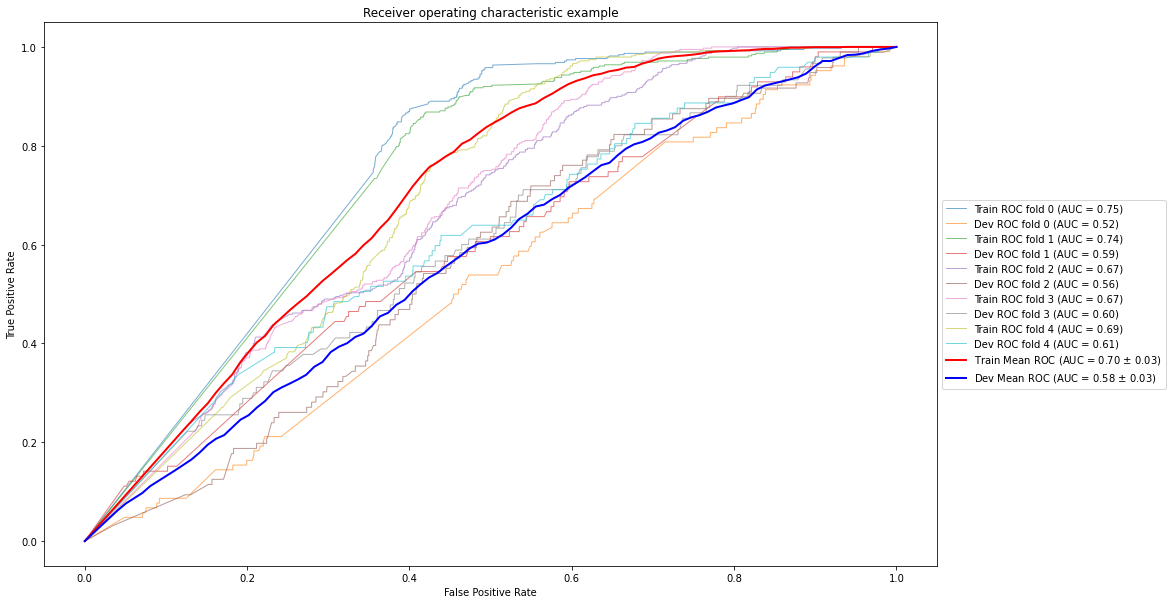

(0.7045021320477476,
 0.5771730723107003,
 [LGBMClassifier(boosting_type='goss', colsample_bytree=0.01, learning_rate=0.001,
                 max_depth=18, n_estimators=1000, num_leaves=15,
                 objective='binary', random_state=42, reg_alpha=50.0,
                 reg_lambda=50.0, subsample_freq=1),
  LGBMClassifier(boosting_type='goss', colsample_bytree=0.01, learning_rate=0.001,
                 max_depth=18, n_estimators=1000, num_leaves=15,
                 objective='binary', random_state=42, reg_alpha=50.0,
                 reg_lambda=50.0, subsample_freq=1),
  LGBMClassifier(boosting_type='goss', colsample_bytree=0.01, learning_rate=0.001,
                 max_depth=18, n_estimators=1000, num_leaves=15,
                 objective='binary', random_state=42, reg_alpha=50.0,
                 reg_lambda=50.0, subsample_freq=1),
  LGBMClassifier(boosting_type='goss', colsample_bytree=0.01, learning_rate=0.001,
                 max_depth=18, n_estimators=1000, num_leaves=1

time: 15 s


In [13]:
from lightgbm import LGBMClassifier

params = {
  'boosting_type': 'goss',
  'objective': 'binary',
  'n_estimators': 1000,
  'num_leaves': 15,
  'max_depth': 18,
#   'subsample_for_bin': 512,
  'learning_rate': 0.001,
  # 'min_child_samples': 100,
  'subsample_freq': 1,
  'subsample': 1.,
  'colsample_bytree': 0.01,
  'reg_alpha': 50.0,
  'reg_lambda': 50.0,
  'random_state':42
}
fit_params={
  'early_stopping_rounds': 50,
  'eval_metric': 'logloss',
  'verbose': False
}

lgm = LGBMClassifier(**params)
cross_validate_auc(lgm, kfold, features=None, evaluate=True, **fit_params)

# CatBoost

In [ ]:
from catboost import CatBoostClassifier

params={
  # 'grow_policy':'Depthwise',
  'loss_function': 'Logloss',
  'eval_metric': 'AUC',
  'iterations': 1000,
  'learning_rate': 0.001,
  'depth': 16,
  'l2_leaf_reg': 50.0,
  # 'max_bin': 127,
  'colsample_bylevel': 0.01,
  'od_type': 'Iter',
  'od_wait': 50,
}
fit_params={
  'early_stopping_rounds': 50,
  'verbose':False
}

cat = CatBoostClassifier(**params)
cross_validate_auc(cat, kfold, features=None, evaluate=True, **fit_params)

# NG Boost

In [ ]:
from ngboost import NGBClassifier
from sklearn.base import ClassifierMixin
from sklearn.utils.multiclass import unique_labels

class MyNGBClassifier(NGBClassifier, ClassifierMixin):
  def fit(self, X, y):
    if type(X) != np.ndarray:
      X_np = X.to_numpy()
    else:
      X_np = X.copy()
    y_np = y.copy()
    if type(y) == pd.Series:
      y_np = y.astype("int64").to_numpy()
    self.classes_ = unique_labels(y)
    return super().fit(X_np, y_np)
  
  def predict(self, X):
    if type(X) != np.ndarray:
      X_np = X.to_numpy()
    else:
      X_np = X.copy()
    return super().predict(X_np)

  def predict_proba(self, X):
    if type(X) != np.ndarray:
      X_np = X.to_numpy()
    else:
      X_np = X.copy()
    return super().predict_proba(X_np)
  

ngb_clf = MyNGBClassifier(n_estimators=250, random_state=42)
cross_validate_auc(ngb_clf, kfold)

# Neural network 

In [ ]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras.regularizers import l1_l2
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.base import BaseEstimator, ClassifierMixin
from imblearn.over_sampling import SMOTE
from collections import Counter

class NeuralNetwork(BaseEstimator, ClassifierMixin):
  
  def __init__(self, architecture_config, training_config, callbacks_config):
    # logger.info('initializing NeuralNetwork ...')
    self.architecture_config_ = architecture_config
    self.model_params_ = architecture_config['model_params']
    self.optimizer_params_ = architecture_config['optimizer_params']
    self.training_config_ = training_config
    self.callbacks_config_ = callbacks_config
    self.classes_ = np.array([0,1])

  def get_params(self, deep=True):
    return {'architecture_config': self.architecture_config_,
            'training_config': self.training_config_,
            'callbacks_config': self.callbacks_config_
            }
    
  def _build_optimizer(self, **kwargs):
    return Adam(**self.optimizer_params_)
  
  def _build_loss(self, **kwargs):
    return 'binary_crossentropy'

  def _build_callbacks(self):
    callbacks = []
    for callback_config in self.callbacks_config_:
      if callback_config == 'EarlyStopping':
        callbacks.append(
            EarlyStopping(
                **self.callbacks_config_[callback_config]
            )
        )
      elif callback_config == 'ModelCheckpoint':
        callbacks.append(
            ModelCheckpoint(
                **self.callbacks_config_[callback_config]
            )
        )
      
    return callbacks

  def _build_model(self, input_shape, **kwargs):
    K.clear_session()
    model = Sequential()
    for layer in range(self.model_params_['layers']):
      config = {key: val[layer] for key, val in self.model_params_.items() if key != 'layers'}
      if layer == 0:
        model.add(Dense(config['neurons'],
                        kernel_regularizer=l1_l2(l1=float(config['l1']), l2=float(config['l2'])),
                        input_shape=input_shape
                        ))
      else:
        model.add(Dense(config['neurons'],
                        kernel_regularizer=l1_l2(l1=config['l1'], l2=config['l2'])
                        ))
      if config['batch_norm']:
        model.add(BatchNormalization())
      model.add(Activation(config['activation']))
      model.add(Dropout(config['dropout']))
    
    return model
  
  def _compile_model(self, input_shape):
    model = self._build_model(input_shape)
    optimizer = self._build_optimizer()
    loss = self._build_loss()
    model.compile(optimizer=optimizer, loss=loss)
    return model
  
  def fit(self, X, y, validation_data=None, *args, **kwargs):
    # logger.info(f'Neural network, fit') 
    # logger.info(f'Neural network, training data shape {X.shape}')
    # logger.info(f'Neural network, training label shape {y.shape}')
    print(Counter(y))
    self.model = self._compile_model(input_shape=(X.shape[1], ))
    
    self.callbacks = self._build_callbacks()
    
    self.model.fit(X,
                    y,
                    validation_data=validation_data,
                    verbose=1,
                    **self.training_config_,
                    callbacks=self.callbacks)
    # logger.info(f'Neural network, done fit') 
    return self
  
  def score(self, X, y, *args, **kwargs):
    return roc_auc_score(y, self.transform(X)) 

  def transform(self, X, *args, **kwargs):
    # logger.info(f'Neural network, transform') 
    # logger.info(f'Neural network, transform, testing shape: {X.shape}')
    pred = self.model.predict(X, verbose=1)
    pred = np.array([x[0] for x in pred]).reshape(-1)
    # logger.info(f'Neural network, transform, predictions shape: {pred.shape}')
    # logger.info(f'Neural network, done transform') 
    return pred
  
  def predict_proba(self, X, *args, **kwargs):
    # logger.info(f'Neural network, predict_proba') 
    # logger.info(f'Neural network, predict_proba, testing shape: {X.shape}')
    pred = self.model.predict(X, verbose=1).reshape(-1)
    pred = np.hstack((np.zeros(pred.shape[0]).reshape(-1), pred)).reshape(-1, 2)
    # logger.info(f'Neural network, predict_proba, done') 
    return pred

params = {
        'architecture_config': {
            'model_params': {
                'layers': 3,
                'neurons': [128, 32, 1],
                'activation': ["relu","relu", "sigmoid"],
                'dropout': [0.3, 0.3, 0.],
                'batch_norm': [True, False, False],
                'l1': [2., 0., 0.],
                'l2': [3., 0., 0.]
            },
            'optimizer_params': {
                'learning_rate': 0.01,
                'beta_1': 0.9,
                'beta_2': 0.99
            }
        },
        'training_config': {
            'epochs': 10,
            'batch_size': 512
        },
        'callbacks_config': {
            # 'EarlyStopping':{
            #     'monitor':'loss',
            #     'patience':30,
            #     'mode':'min'
            #     },
        },
    }

nn = NeuralNetwork(**params)


sm = SMOTE(sampling_strategy = 0.1, random_state=31)
kfold_nn = []
for i in range(5):
  X_train_new, y_train_new = sm.fit_resample(kfold[i]['X_train'], kfold[i]['y_train'])
  X_train_new = pd.DataFrame(X_train_new, columns=kfold[i]['X_train'].columns)
  kfold_nn.append({
      'X_train':X_train_new,
      'X_dev':kfold[i]['X_dev'],
      'y_train':y_train_new,
      'y_dev': kfold[i]['y_dev']
      })
cross_validate_auc(nn, kfold, nn_validate=True)

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
params={
  'penalty': 'elasticnet',
  'tol': 1e-3,
  'C': 5,
  'fit_intercept': True,
  # 'class_weight': 'balanced',
  'solver': 'saga',
  'max_iter': 100,
  'l1_ratio':0
}

logit = LogisticRegression(**params)
cross_validate_auc(logit, kfold)

# Deep Neural Decision Tree

In [ ]:
# import tensorflow as tf
# print(tf.__version__)
# from functools import reduce


# def tf_kron_prod(a, b):
#     res = tf.einsum('ij,ik->ijk', a, b)
#     res = tf.reshape(res, [-1, tf.reduce_prod(res.shape[1:])])
#     return res


# def tf_bin(x, cut_points, temperature=0.1):
#     # x is a N-by-1 matrix (column vector)
#     # cut_points is a D-dim vector (D is the number of cut-points)
#     # this function produces a N-by-(D+1) matrix, each row has only one element being one and the rest are all zeros
#     D = cut_points.get_shape().as_list()[0]
#     W = tf.reshape(tf.linspace(1.0, D + 1.0, D + 1), [1, -1])
#     cut_points = tf.contrib.framework.sort(cut_points)  # make sure cut_points is monotonically increasing
#     b = tf.cumsum(tf.concat([tf.constant(0.0, shape=[1]), -cut_points], 0))
#     h = tf.matmul(x, W) + b
#     res = tf.nn.softmax(h / temperature)
#     return res


# def nn_decision_tree(x, cut_points_list, leaf_score, temperature=0.1):
#     # cut_points_list contains the cut_points for each dimension of feature
#     leaf = reduce(tf_kron_prod,
#                   map(lambda z: tf_bin(x[:, z[0]:z[0] + 1], z[1], temperature), enumerate(cut_points_list)))
#     return tf.matmul(leaf, leaf_score)
  
# for i in range(0,5):
#     X_train, X_dev = kfold[i]['X_train'], kfold[i]['X_dev']
#     y_train, y_dev = kfold[i]['y_train'], kfold[i]['y_dev']
    
#     d = X_train.shape[1]
#     num_cut = [1]*X_train.shape[1]
#     num_leaf = np.prod(np.array(num_cut) + 1)
#     num_class = 2
#     sess= tf.InteractiveSession()
   
#     x_ph = tf.placeholder(tf.float32, [None, d])
#     y_ph = tf.placeholder(tf.float32, [None, num_class])
#     cut_points_list = [tf.Variable(tf.random_uniform([i])) for i in num_cut]
#     leaf_score = tf.Variable(tf.random_uniform([num_leaf, num_class]))
#     y_pred = nn_decision_tree(x_ph, cut_points_list, leaf_score, temperature=0.01)
#     loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(logits=y_pred, onehot_labels=y_ph))
#     opt = tf.train.AdamOptimizer(0.1).minimize(loss)
        
#     sess.run(tf.global_variables_initializer())
#     for i in range(100):
#         _ , loss_e = sess.run([opt, loss], feed_dict={x_ph: X_train, y_ph: y_train})
#         if i%10 == 0:
#             print(loss_e)
#     print(f'error rate {1 - np.mean(np.argmax(y_pred.eval(feed_dict={x_ph: X_train}), axis=1) == np.argmax(y_train, axis=1))}')
        
    
